In [5]:
from pycaret.datasets import get_data
from pycaret.clustering import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering, Birch
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA

import pandas as pd
from sklearn.datasets import load_wine
from pycaret.clustering import *
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [6]:
from pycaret.datasets import get_data
dataSets = get_data('index',verbose=False)
dataSets[dataSets['Default Task']=='Clustering']

,Dataset,Data Types,Default Task,Target Variable 1,Target Variable 2,# Instances,# Attributes,Missing Values
26,asia_gdp,Multivariate,Clustering,None,None,40,11,N
27,elections,Multivariate,Clustering,None,None,3195,54,Y
28,facebook,Multivariate,Clustering,None,None,7050,12,N
29,ipl,Multivariate,Clustering,None,None,153,25,N
30,jewellery,Multivariate,Clustering,None,None,505,4,N
31,mice,Multivariate,Clustering,None,None,1080,82,Y
32,migration,Multivariate,Clustering,None,None,233,12,N
33,perfume,Multivariate,Clustering,None,None,20,29,N
34,pokemon,Multivariate,Clustering,None,None,800,13,Y
35,population,Multivariate,Clustering,None,None,255,56,Y


,area,perimeter,compactness,length,width,asymmetry,length.1
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175


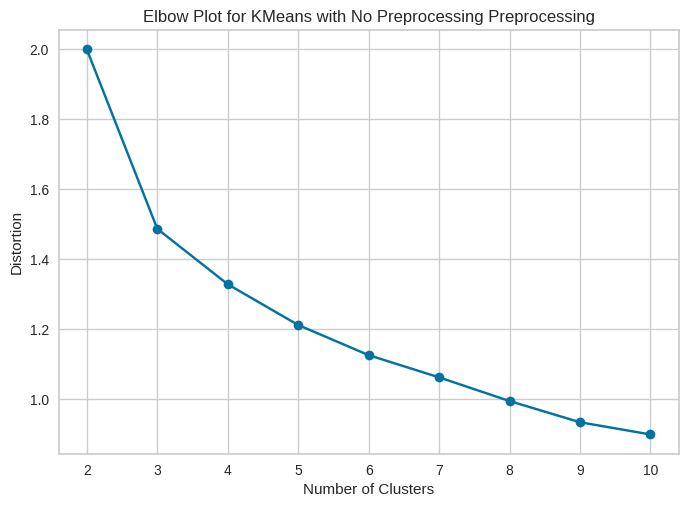

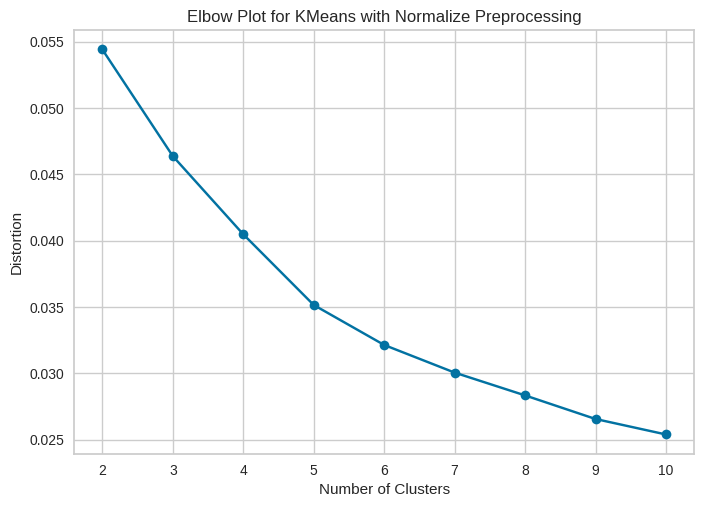

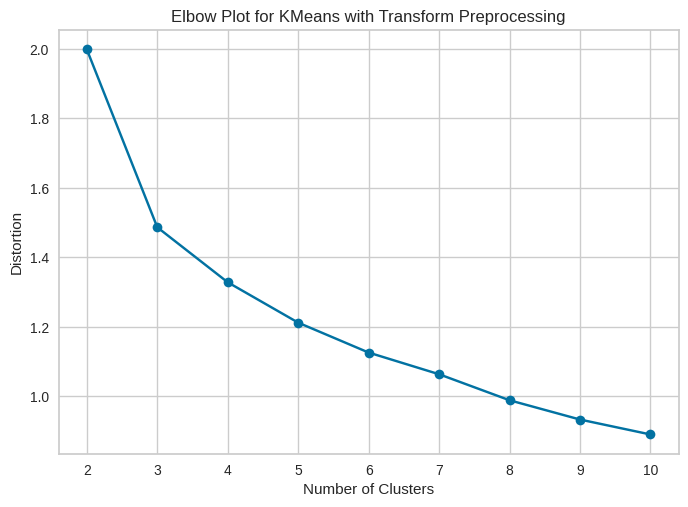

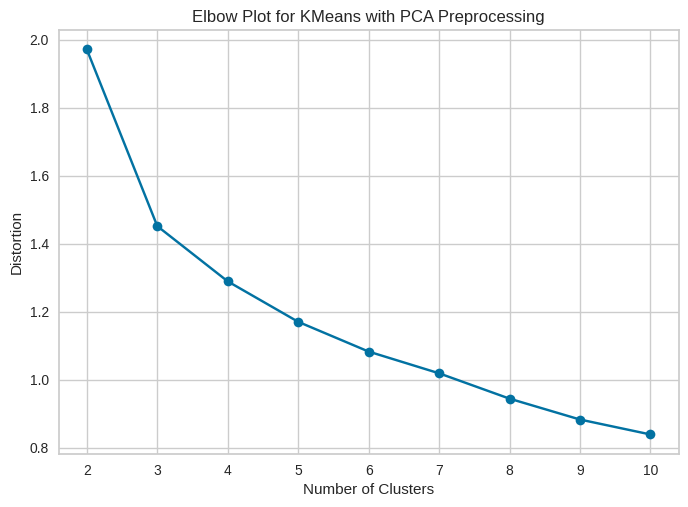

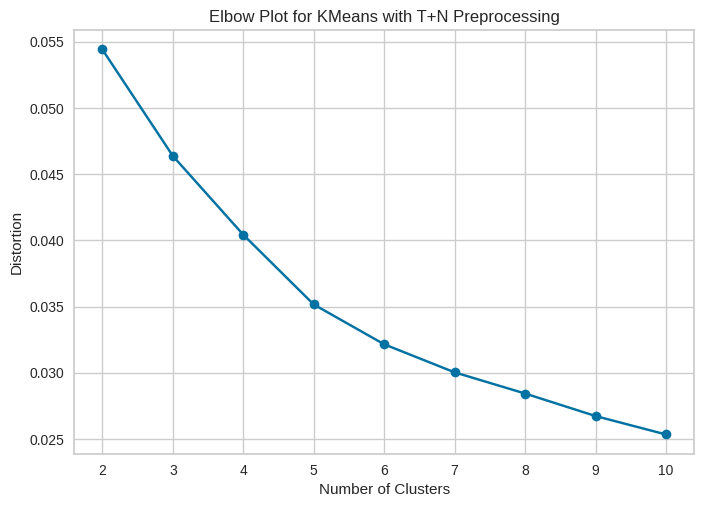

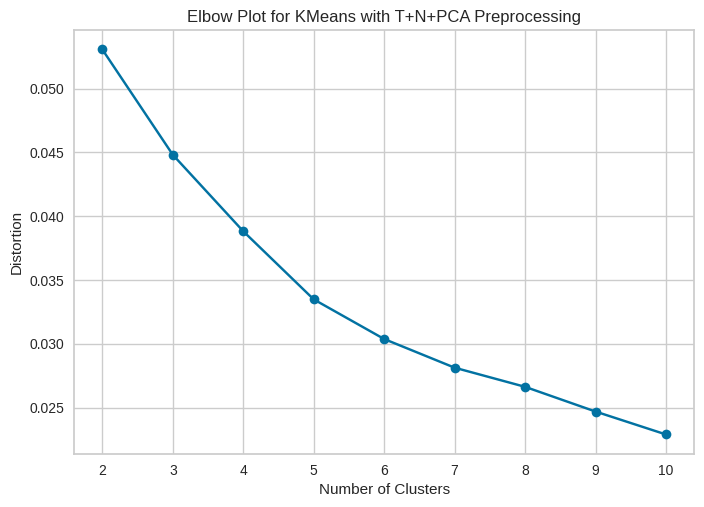

In [7]:
seedsDataSet = get_data("seeds")

X = seedsDataSet
X = X.dropna()
# Define preprocessing approaches
preprocessing = {
    'No Preprocessing': lambda x: x,
    'Normalize': normalize,
    'Transform': lambda x: x,  # Replace with your own transformation function
    'PCA': lambda x: PCA(n_components=2).fit_transform(x),
    'T+N': lambda x: normalize(x),
    'T+N+PCA': lambda x: PCA(n_components=2).fit_transform(normalize(x))
}

# Define the number of clusters for the elbow plot
clusters_range = range(2, 11)

# Generate elbow plots for KMeans, Hierarchical, and Birch
for model_name, model in [('KMeans', KMeans()), ('Hierarchical', linkage), ('Birch', Birch())]:
    for preprocess_column, preprocess_func in preprocessing.items():
        X_preprocessed = preprocess_func(X)

        if model_name == 'KMeans':
            distortions = []
            for cluster in clusters_range:
                kmeans = KMeans(n_clusters=cluster)
                kmeans.fit(X_preprocessed)
                distortions.append(sum(np.min(cdist(X_preprocessed, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X_preprocessed.shape[0])

            # Plot the elbow plot for KMeans
            plt.plot(clusters_range, distortions, marker='o')
            plt.title(f'Elbow Plot for {model_name} with {preprocess_column} Preprocessing')
            plt.xlabel('Number of Clusters')
            plt.ylabel('Distortion')
            plt.show()



In [8]:
data = X

# Define preprocessing approaches using PyCaret
preprocessing_pycaret = {
    'No Preprocessing': None,
    'Normalize': 'normalize',
    'Transform': 'transformation',
    'PCA': 'pca',
    'T+N': ['normalize', 'transformation'],
    'T+N+PCA': ['normalize', 'transformation', 'pca']
}

# Define clustering algorithms using PyCaret with corresponding model names
clustering_algorithms = {
    'kmeans': 'K-Means',
    'hclust': 'Hierarchical',
    'birch': 'Birch'
}

# Create DataFrames to store the results for each algorithm
index = ['Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin']
columns = pd.MultiIndex.from_product([['No Preprocessing', 'Normalize', 'Transform', 'PCA', 'T+N', 'T+N+PCA'], ['c=3', 'c=4', 'c=5']], names=['Preprocessing', 'Clusters'])
results_df = pd.DataFrame(index=index, columns=columns)

# Perform clustering for each combination of preprocessing, algorithm, and clusters using PyCaret
for preprocess_column, preprocess_steps in preprocessing_pycaret.items():
    for algorithm, model_name in clustering_algorithms.items():
        print(f"Model name: {model_name} and Preprocessing used: {preprocess_column}")
        for c in columns.get_level_values('Clusters').unique():
            print(c)
            # Setup PyCaret clustering
            setup(data, normalize=preprocess_steps, transformation=preprocess_steps, verbose=False, pca=preprocess_steps)

            # Create and evaluate the clustering model

            model = create_model(algorithm, num_clusters=int(c[-1]))
            prediction = assign_model(model)

            # Calculate clustering metrics
            labels_column = 'Cluster'  # Adjusted labels column name
            silhouette_score_val = silhouette_score(data, prediction[labels_column])
            calinski_harabasz_index_val = calinski_harabasz_score(data, prediction[labels_column])
            davies_bouldin_index_val = davies_bouldin_score(data, prediction[labels_column])

            # Update the results DataFrame with model name
            results_df.loc[:, (f'{model_name} - {preprocess_column}', c)] = [silhouette_score_val, calinski_harabasz_index_val, davies_bouldin_index_val]



Model name: K-Means and Preprocessing used: No Preprocessing
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4714,370.1834,0.7563,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4140,323.7789,0.8202,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3698,305.5449,0.8789,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: Hierarchical and Preprocessing used: No Preprocessing
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4517,340.9871,0.7838,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3717,288.0575,0.8914,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3394,268.1505,0.8636,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: Birch and Preprocessing used: No Preprocessing
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4003,282.0377,0.8620,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3627,298.1573,0.9198,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3571,281.8177,0.8779,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: K-Means and Preprocessing used: Normalize
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4048,230.8074,0.9657,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3307,184.2072,1.2511,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3051,159.3756,1.2617,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: Hierarchical and Preprocessing used: Normalize
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3958,219.6694,1.0000,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3659,170.3120,1.3357,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2806,145.4129,1.4327,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: Birch and Preprocessing used: Normalize
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3569,199.9033,1.0177,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3197,151.1836,1.3158,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3061,139.3696,1.3319,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: K-Means and Preprocessing used: Transform
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4048,230.8074,0.9657,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3307,184.2072,1.2511,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2991,159.9265,1.3202,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: Hierarchical and Preprocessing used: Transform
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3958,219.6694,1.0000,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3659,170.3120,1.3357,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2806,145.4129,1.4327,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: Birch and Preprocessing used: Transform
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3569,199.9033,1.0177,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3197,151.1836,1.3158,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3061,139.3696,1.3319,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: K-Means and Preprocessing used: PCA
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4044,230.8298,0.9662,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3307,184.2072,1.2511,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3006,159.9614,1.3054,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: Hierarchical and Preprocessing used: PCA
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3958,219.6694,1.0000,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3659,170.3120,1.3357,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2806,145.4129,1.4327,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: Birch and Preprocessing used: PCA
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3569,199.9033,1.0177,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3197,151.1836,1.3158,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3061,139.3696,1.3319,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: K-Means and Preprocessing used: T+N
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4048,230.8074,0.9657,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3307,184.2072,1.2511,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2985,157.7714,1.3476,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: Hierarchical and Preprocessing used: T+N
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3958,219.6694,1.0000,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3659,170.3120,1.3357,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2806,145.4129,1.4327,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: Birch and Preprocessing used: T+N
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3569,199.9033,1.0177,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3197,151.1836,1.3158,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3061,139.3696,1.3319,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: K-Means and Preprocessing used: T+N+PCA
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4048,230.8074,0.9657,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3337,184.1507,1.2456,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2977,159.6476,1.2838,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: Hierarchical and Preprocessing used: T+N+PCA
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3958,219.6694,1.0000,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3659,170.3120,1.3357,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2806,145.4129,1.4327,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: Birch and Preprocessing used: T+N+PCA
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3569,199.9033,1.0177,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3197,151.1836,1.3158,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3061,139.3696,1.3319,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

In [9]:
results_df = results_df.dropna(axis=1)
display(results_df)
# Save the results to a CSV file
results_df.to_csv('pycaret_results.csv', index=True)

Preprocessing     K-Means - No Preprocessing                          \
Clusters                                 c=3         c=4         c=5   
Silhouette                          0.471386    0.414045    0.369847   
Calinski-Harabasz                 370.183448  323.778755  305.544787   
Davies-Bouldin                      0.756313    0.820215    0.878868   

Preprocessing     Hierarchical - No Preprocessing                          \
Clusters                                      c=3         c=4         c=5   
Silhouette                               0.451733    0.371727    0.339357   
Calinski-Harabasz                      340.987197  288.057405  268.150485   
Davies-Bouldin                           0.783829    0.891387    0.863589   

Preprocessing     Birch - No Preprocessing                          \
Clusters                               c=3         c=4         c=5   
Silhouette                        0.400335    0.362668    0.357117   
Calinski-Harabasz               282.037646  298.157272  281.817608   
Davies-Bouldin                    0.861963    0.919786    0.877909   

Preprocessing     K-Means - Normalize  ... Birch - T+N K-Means - T+N+PCA  \
Clusters                          c=3  ...         c=5               c=3   
Silhouette                   0.441924  ...    0.266878          0.441924   
Calinski-Harabasz          330.976147  ...  180.305053        330.976147   
Davies-Bouldin               0.778873  ...    1.195025          0.778873   

Preprocessing                             Hierarchical - T+N+PCA              \
Clusters                  c=4         c=5                    c=3         c=4   
Silhouette           0.334458    0.298902               0.425563    0.352502   
Calinski-Harabasz  268.562684  244.050816             297.983030  218.455039   
Davies-Bouldin       1.078828    1.078570               0.846201    1.553628   

Preprocessing                 Birch - T+N+PCA                          
Clusters                  c=5             c=3         c=4         c=5  
Silhouette           0.307476        0.347808    0.287197    0.266878  
Calinski-Harabasz  214.404043      255.264451  191.938326  180.305053  
Davies-Bouldin       1.473382        0.964146    1.050655    1.195025  

[3 rows x 54 columns]